In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta
plt.rcParams['figure.dpi'] = 144

In [2]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/datadesk/california-coronavirus-data/master/latimes-county-totals.csv",
    index_col=0,
    parse_dates=[0]
).sort_index()

df.index = df.index.tz_localize(tz='US/Pacific')
df = df[df["county"] == "Los Angeles"]

In [3]:
# Smooth out May 27 data dump
df.loc["2021-05-27", "new_confirmed_cases"] = 200
df.loc["2021-05-27", "new_deaths"] = 10

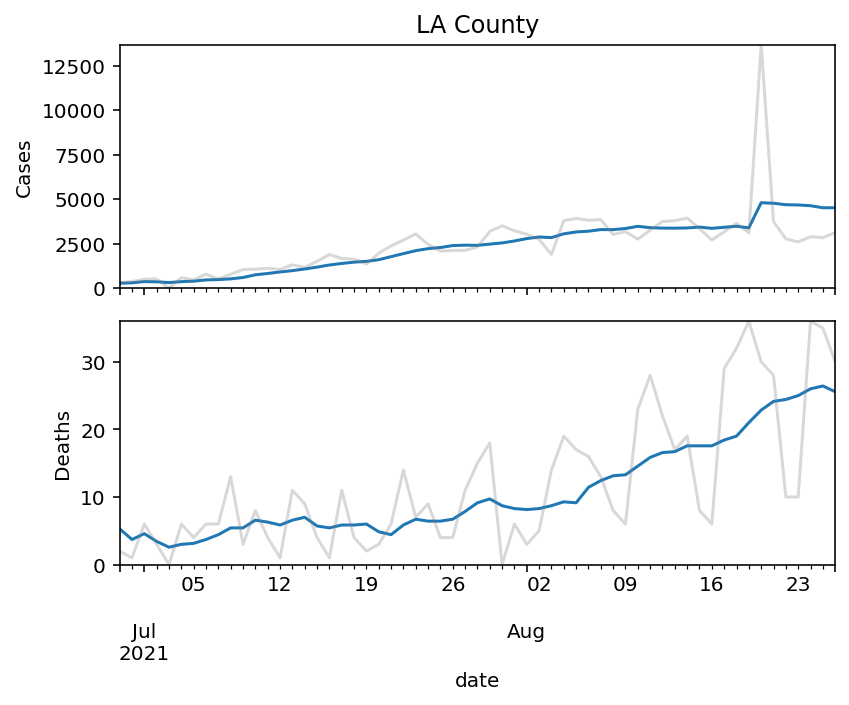

In [4]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(6, 5))


df.new_confirmed_cases.rolling(window=7).mean().plot(ax=axs[0])
df.new_confirmed_cases.plot(alpha=0.3, ax=axs[0], color='gray')
df.new_deaths.rolling(window=7).mean().plot(ax=axs[1])
df.new_deaths.plot(alpha=0.3, ax=axs[1], color='gray')

start = datetime.now(tz=timezone.utc) - timedelta(days=60)

axs[0].set_xlim(datetime.now(tz=timezone.utc) - timedelta(days=60), None)
axs[0].set_ylim(0, df[start:].new_confirmed_cases.max());
axs[1].set_ylim(0, df[start:].new_deaths.max());
axs[0].set_ylabel("Cases");
axs[1].set_ylabel("Deaths");

axs[0].set_title("LA County")
fig.tight_layout()
fig.set_facecolor("white")
fig.savefig("lacounty.png", bbox_inches="tight")